In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Geometry import Point3D

from tqdm import tqdm_notebook

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import numpy as np

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

from xyz2mol import *

RDKit WARNING: [00:37:25] Enabling RDKit 2019.09.1 jupyter extensions


# Load a small dataset of 200 isomers of C7O9

In [2]:
mols = list()
smiles = [i.strip('\n') for i in open('small_dataset.smi', 'r').readlines()]
for smi in tqdm_notebook(smiles):
    mols.append(Chem.MolFromSmiles(smi))

In [38]:
from rdkit.Chem.Draw import MolToImage

In [81]:
imgs=[]
# Convert mols to grayscale pixel vectors
for i in mols:
    imgs.append((np.array(MolToImage(i, size=(60,60)).convert('L'))).flatten())

In [85]:
imgs=np.array(imgs)

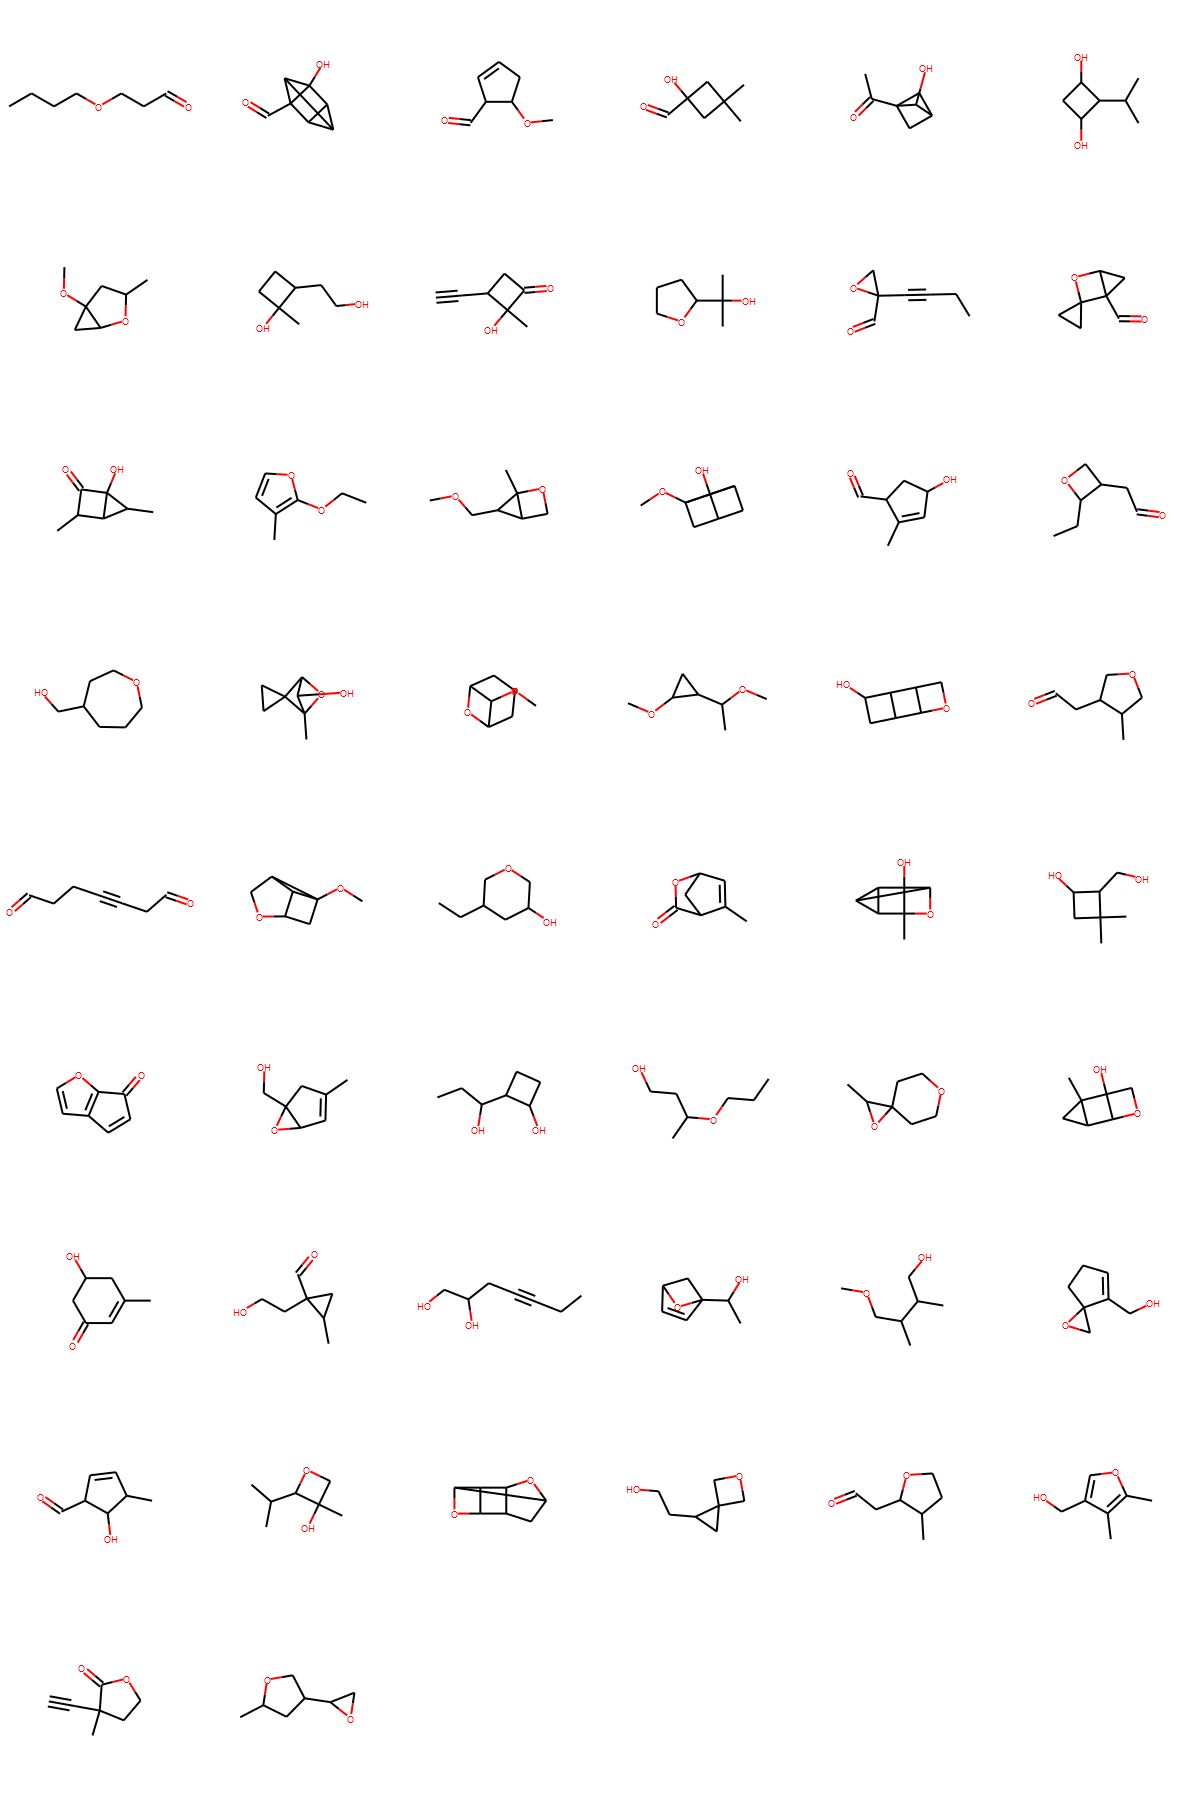

In [209]:
Draw.MolsToGridImage(mols[150:200], molsPerRow=6)

# [exploratory] GMM fitting on data, with PCA to reduce dimensionality.


This uses code from https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

##fitting GMM to Mol structural diagrams


In [87]:
imgs.shape

(200, 3600)

# PCA:
We can reduce the number of dimensions substantially using a PCA, and then just turn it back into full number later using the inverse_transform method:

In [88]:
##reduce noise using pca?
pca = PCA(0.99, whiten=True) ##keep 99 percent of variance. 
data = pca.fit_transform(imgs)

In [90]:
##structural diagrams are apparantly very redundant
print('Went from:', imgs.shape, 'dimensions to:', data.shape)

Went from: (200, 3600) dimensions to: (200, 184)


# GMM:

How many components does the GMM need? Low AIC is better. 
The below plots AIC vs dimensions, and shows we need a lot of dims for just 13 atoms... it might become infeasible for drug like molecules but this is just a baseline.

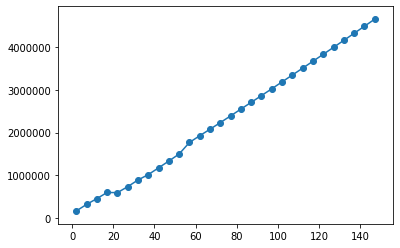

In [170]:
n_components = np.arange(2, 150, 5)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data[:1000]).aic(data) for model in models]
plt.plot(n_components, aics);
plt.scatter(n_components, aics);

In [365]:
gmm = GaussianMixture(30, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


# Example produced molecule:

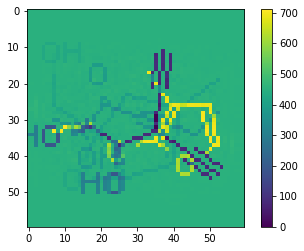

In [366]:
data_new = np.array(gmm.sample(200)[0])
# atomidentities = data_new[-9:]
# print(np.around(atomidentities, 4))
# data_new = data_new[97]
new_sample =pca.inverse_transform([data_new[198]])
new_sample = new_sample-np.min(new_sample)

plt.imshow(new_sample.reshape(60,60))
plt.colorbar()

In [367]:
##plot many samples
data_new=pca.inverse_transform(data_new)

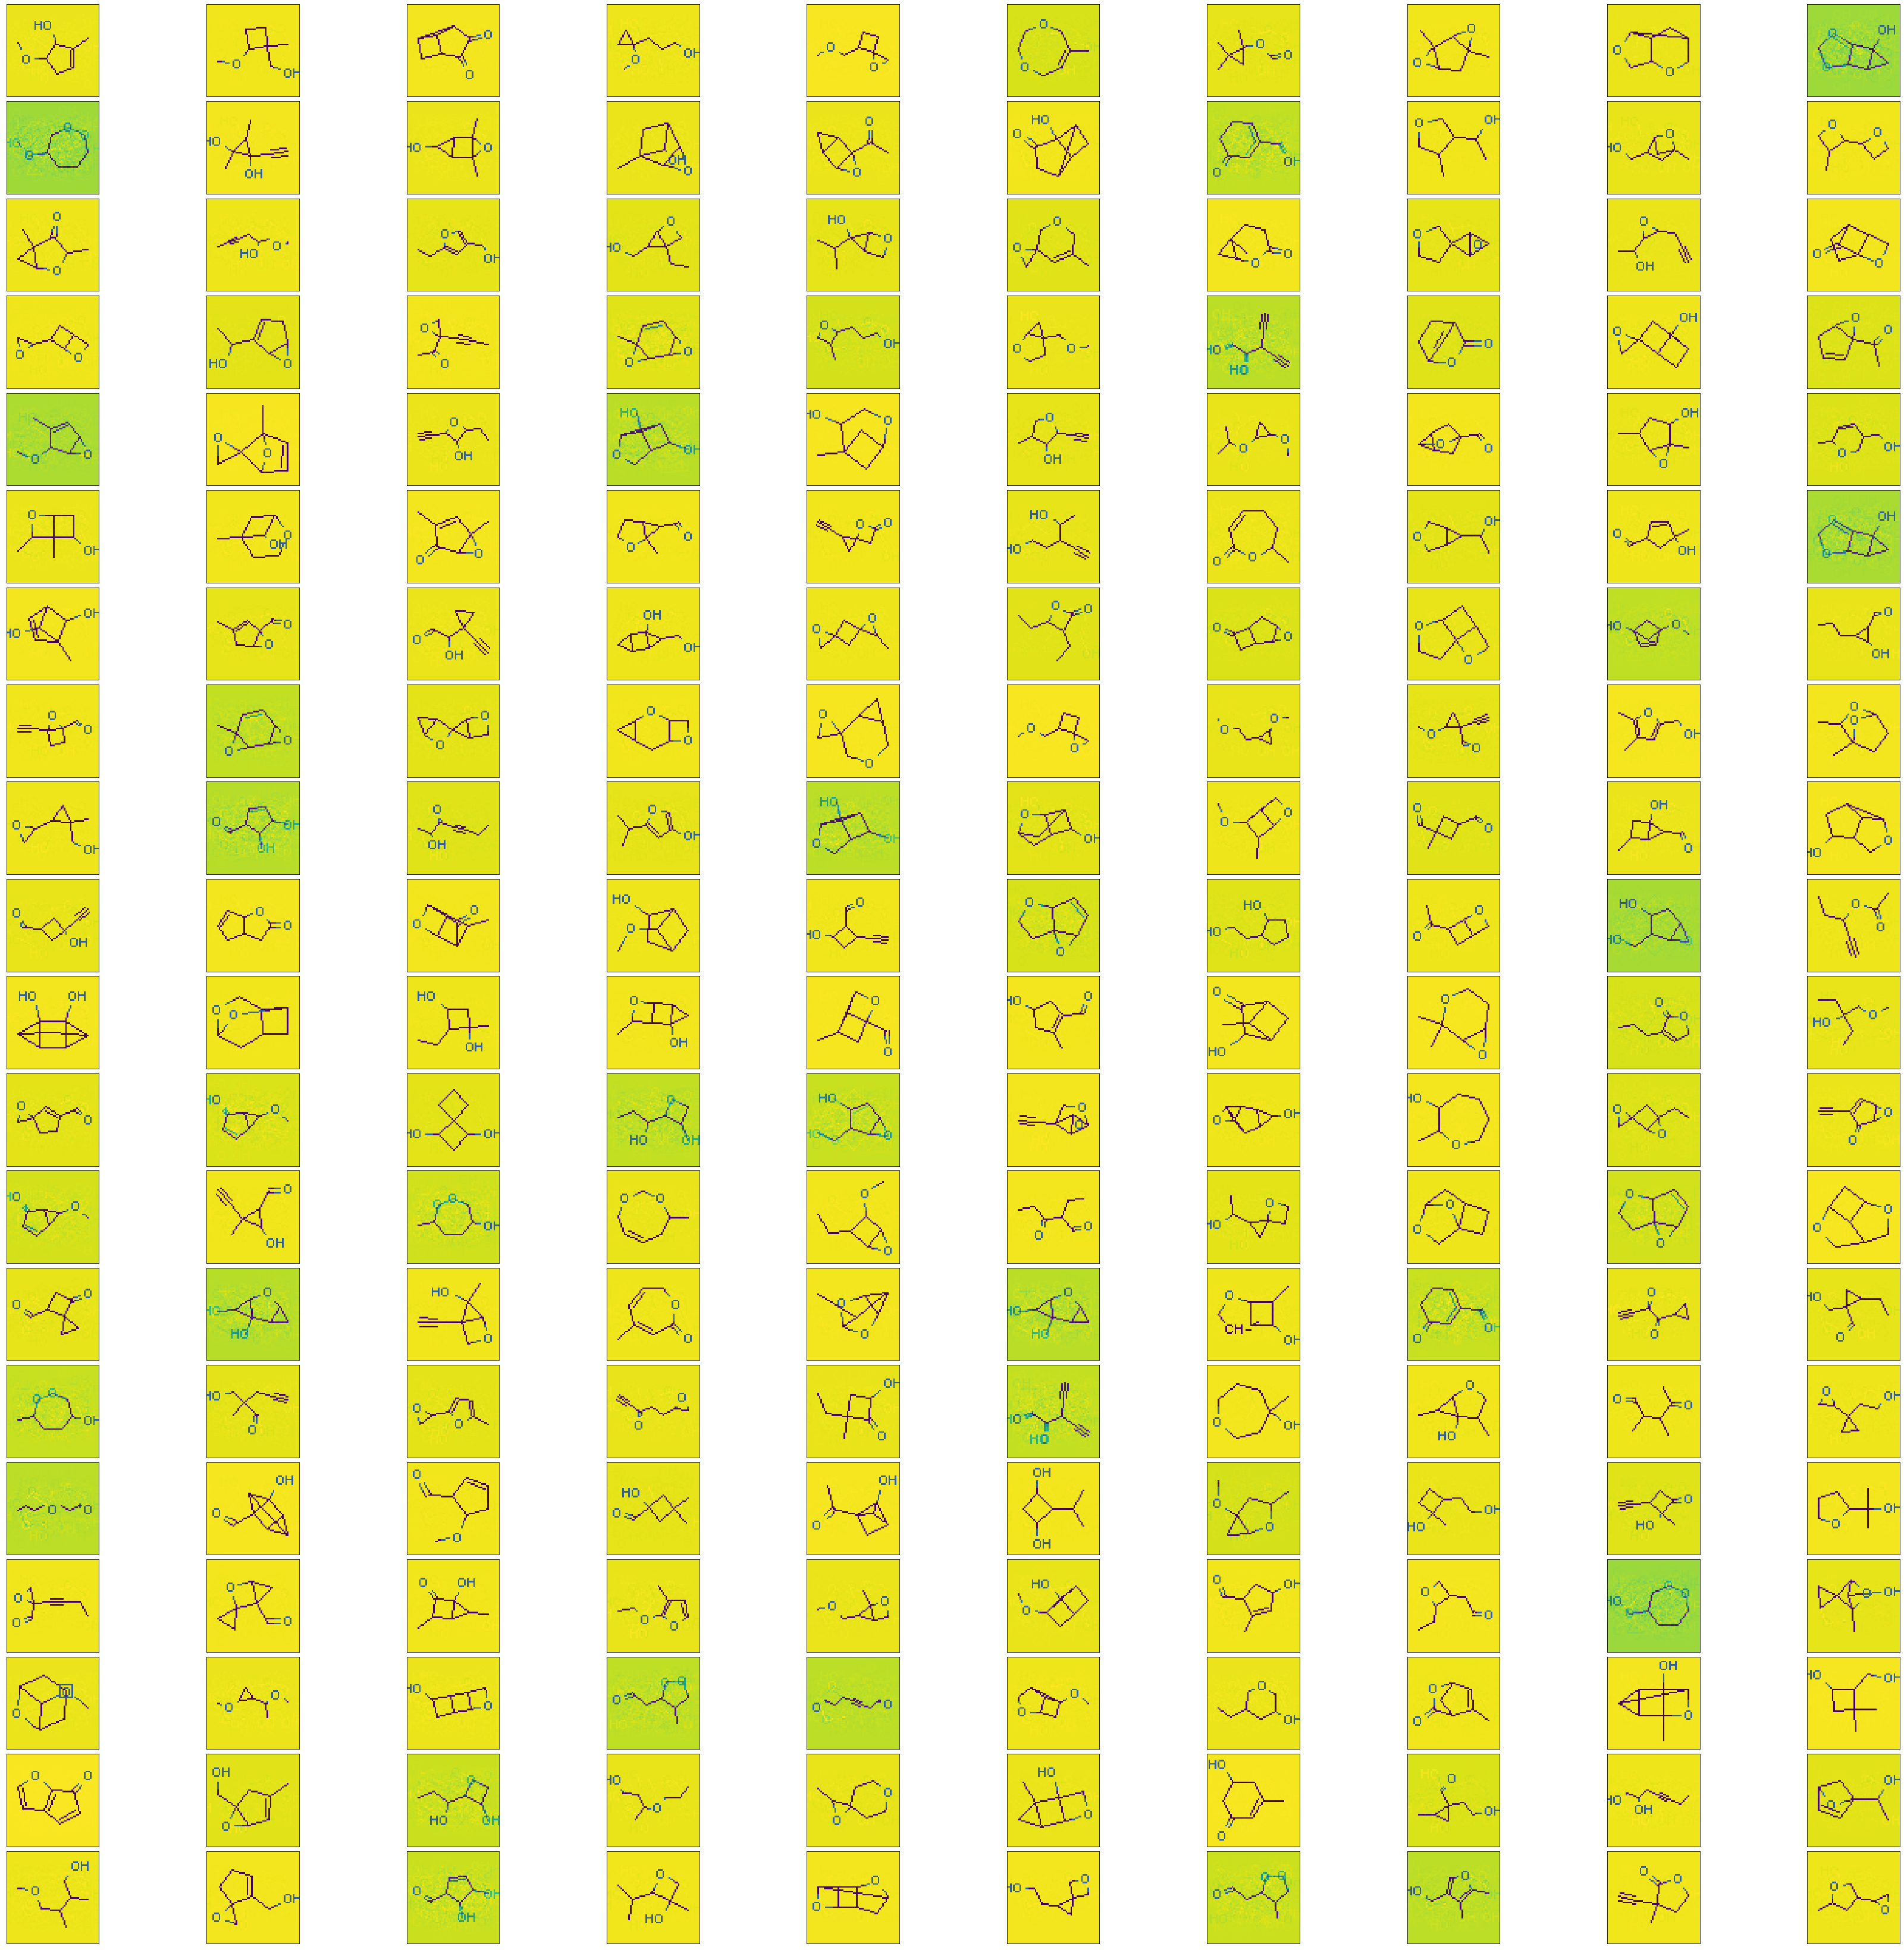

In [368]:
def plot_mols(data):
    fig, ax = plt.subplots(20, 10, figsize=(60, 60),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(60, 60))
plot_mols(data_old)

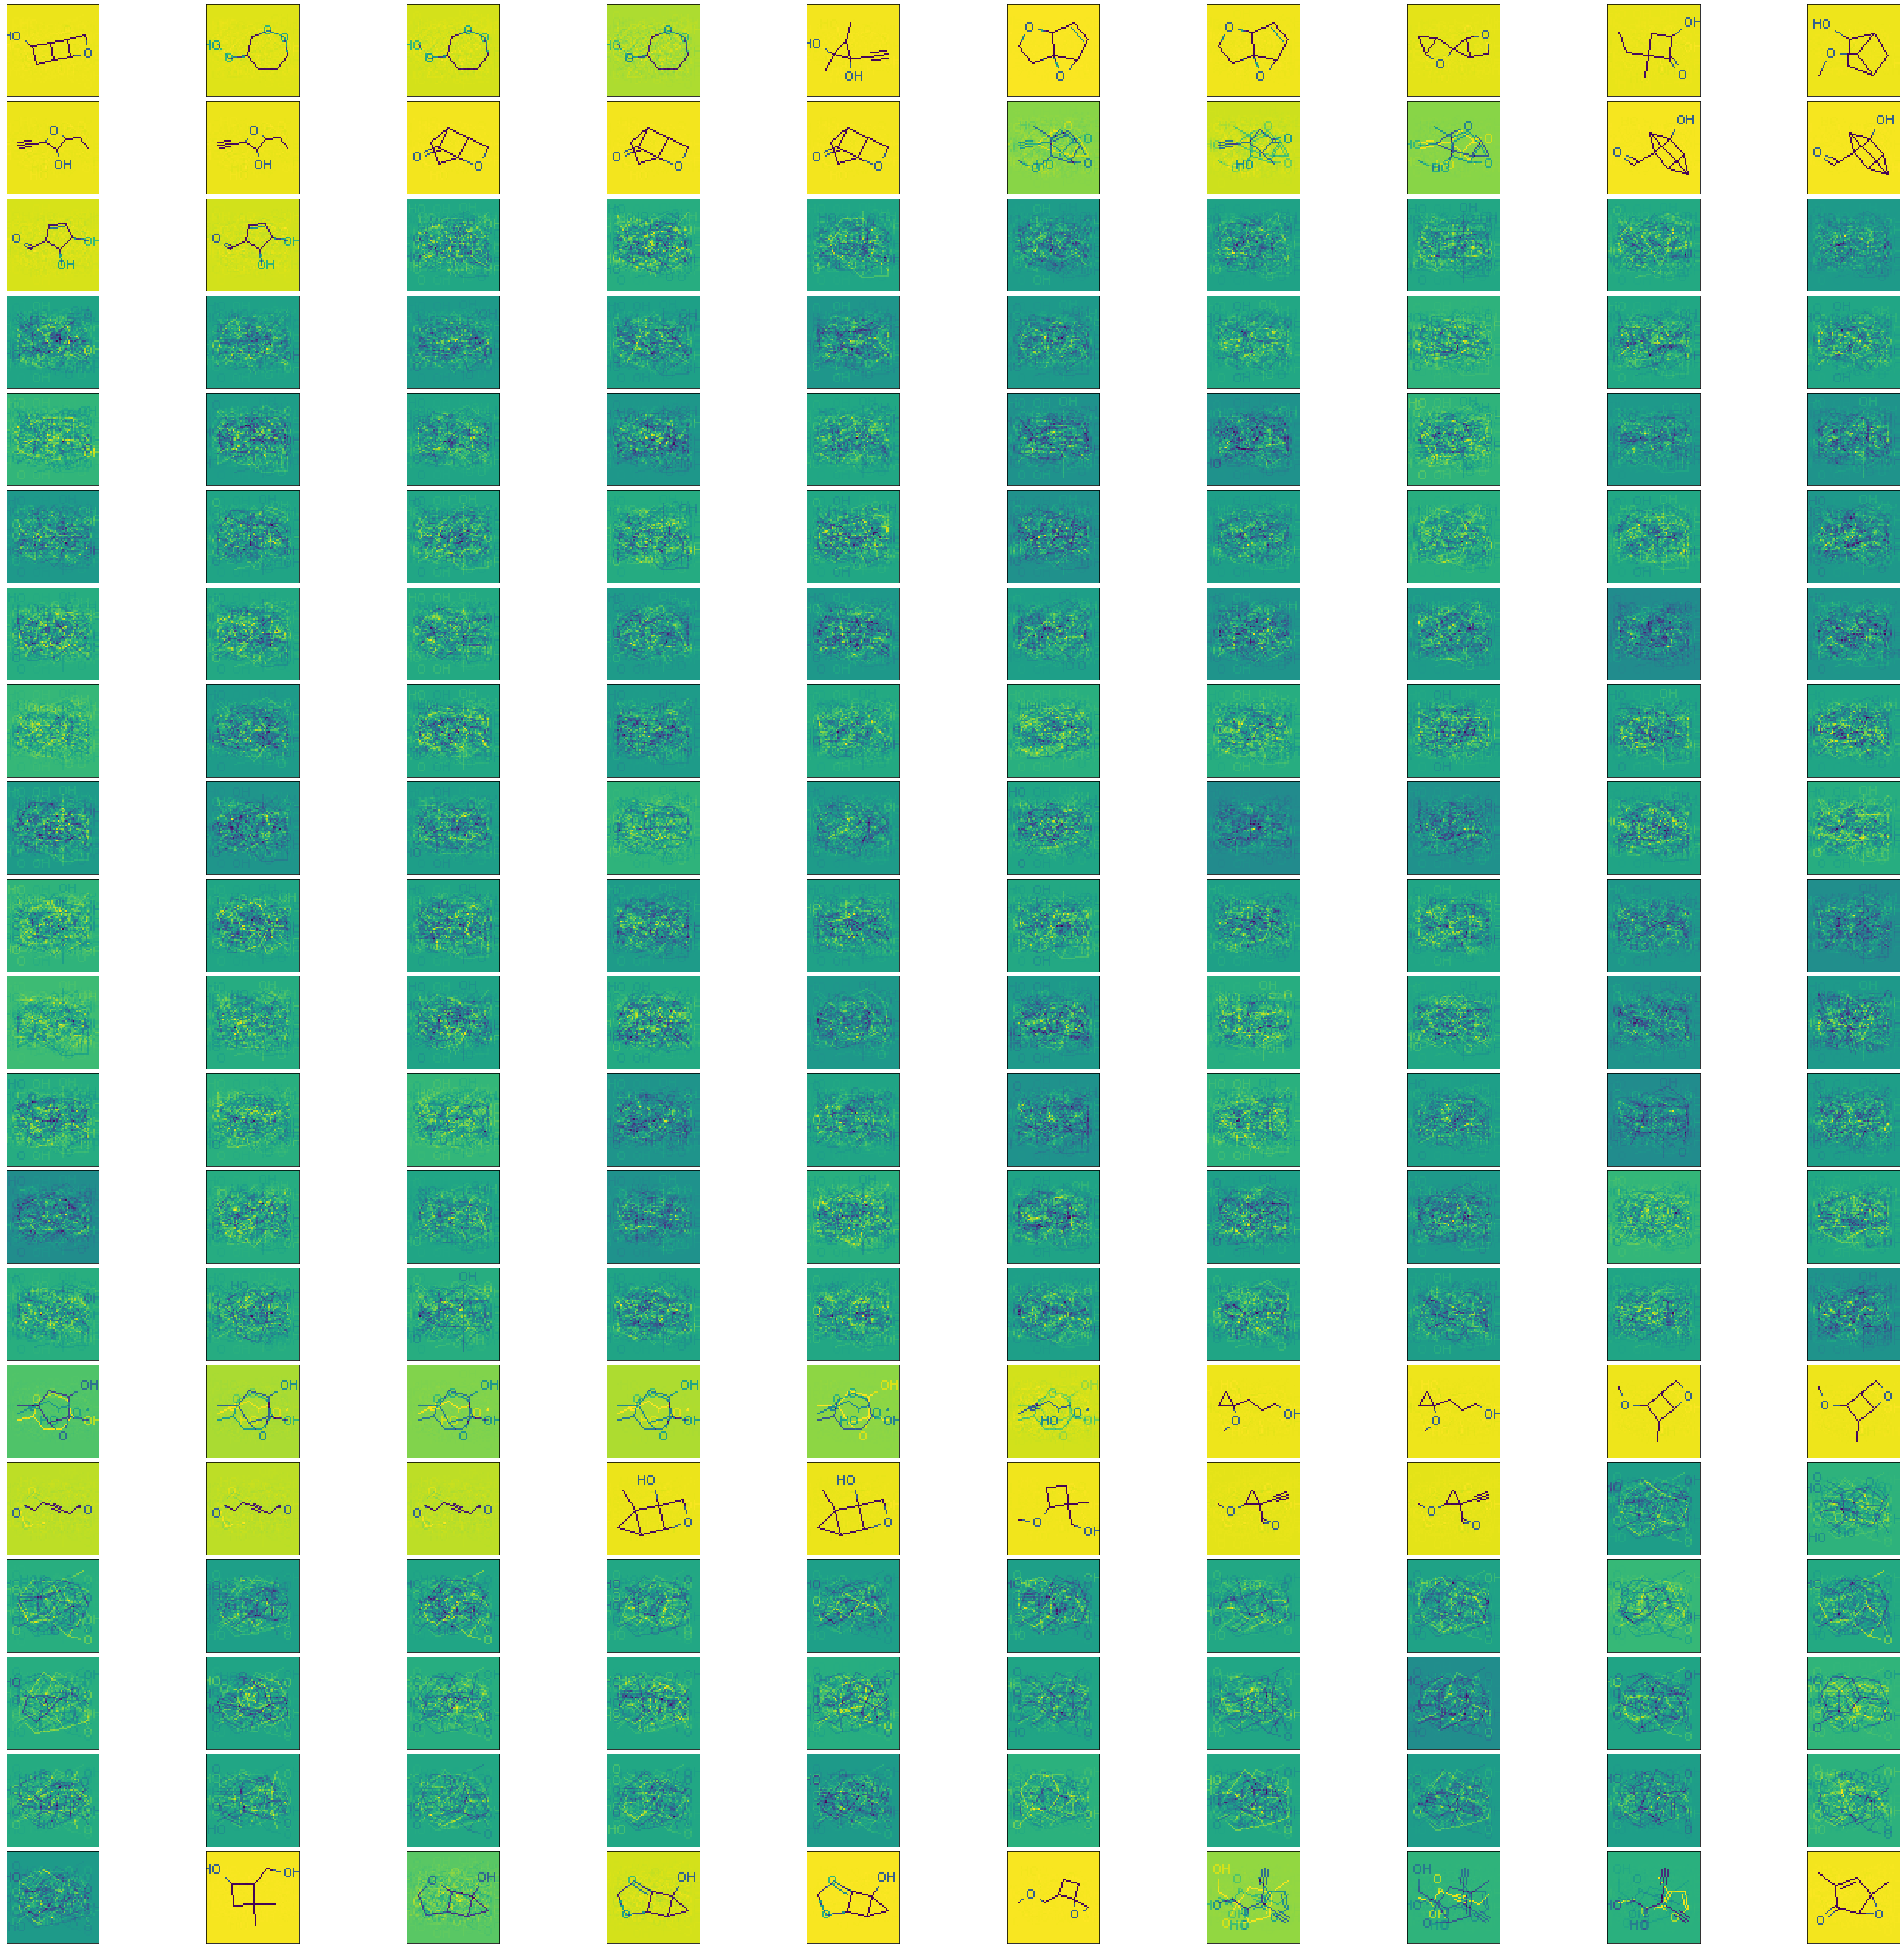

In [369]:
plot_mols(data_new)

In [355]:
data_old=pca.inverse_transform(data)

In [356]:
data_old.shape

(200, 3600)

In [336]:
data_new.shape

(200, 3600)

In [337]:
np.sum(abs(data_old[1]-data_new[198]))

65002.26473678354

In [382]:
candidate_mol=data_new[199]
lowest=np.sum(abs(data_old[0]-candidate_mol))
index=0
for i in data_old:
    distance=np.sum(abs(i-candidate_mol))
    if distance<lowest:
        lowest=distance
        lowest_index=index
    index+=1
    

In [383]:
print(lowest_index)
print(lowest)

52
85.62460312224317


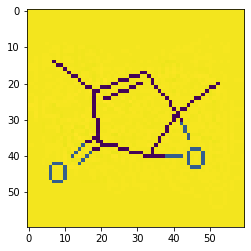

In [384]:
plt.imshow(data_old[lowest_index].reshape(60,60))

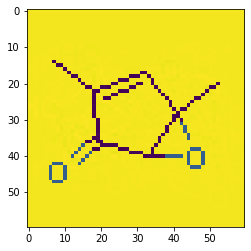

In [385]:
plt.imshow(candidate_mol.reshape(60,60))